In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from tslearn.metrics import dtw, soft_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.utils.validation import _check_large_sparse
from tslearn.clustering import TimeSeriesKMeans
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

/home/roya/miniconda3/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/home/roya/miniconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


We are dealing with AU values only, using all_videos.csv that we had generated before.

We group the data by file name and face id (to seperate emotions as much as possible) and then split the big chunks of frames to smaller chunks of $50$ frames.

In [2]:
X_df = pd.read_csv('./all_videos.csv', index_col=None)
# target_emotion = 'contempt'
# target_culture = 'North America'
# X_df = X_df[(X_df['emotion'] == target_emotion) & (X_df['culture'] == target_culture)]
print(X_df.head())
# filenames = X['filename'].unique()
# face_ids = X['face_id'].unique()
videos = X_df['filename'].unique()
test_videos = pd.Series(videos).sample(frac=0.20)
valid_videos = pd.Series(test_videos).sample(frac=0.50).values
train_videos = np.array(list(set(videos) - set(test_videos)))
test_videos = np.array(list(set(test_videos) - set(valid_videos)))


   frame  face_id  confidence  success  AU01_r  AU02_r  AU04_r  AU05_r  \
0     33        0        0.98        1    0.94    1.24    1.96    2.17   
1     34        0        0.98        1    0.83    0.83    2.65    2.01   
2     35        0        0.98        1    0.78    0.95    2.69    1.68   
3     36        0        0.98        1    1.11    1.06    2.77    1.34   
4     37        0        0.98        1    1.13    0.92    2.60    1.09   

   AU06_r  AU07_r  ...  AU14_r  AU15_r  AU17_r  AU23_r  AU25_r  AU26_r  \
0    0.29     0.0  ...    0.15    0.35    1.31     0.0    1.35    0.00   
1    0.29     0.0  ...    0.79    0.37    1.40     0.0    1.35    0.13   
2    0.18     0.0  ...    0.92    0.34    1.14     0.0    1.42    0.25   
3    0.26     0.0  ...    1.09    0.47    0.66     0.0    1.74    0.00   
4    0.37     0.0  ...    1.30    0.16    0.59     0.0    1.42    0.00   

   AU45_r  filename  culture   emotion  
0    0.00        28  Persian  contempt  
1    0.26        28  Persian

TODO: Also do without frame limit.

In [3]:
grouped = X_df.groupby(by=['filename', 'face_id'])
## Separating test data
test_ts_list = list()
test_metadata = list()
# X_list is video/face frames, divided into 50 frames chunks
X_list = []
metadata = []
frame_limit = 50
for key in grouped.groups:
    X_group = grouped.get_group(key)
    # X_group = X_group.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1)
    if len(X_group) >= frame_limit:
        splitted_group = np.array_split(X_group, math.ceil(len(X_group) / frame_limit))
        for g in splitted_group:
            X_list.append(g.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1).to_numpy())
            metadata.append({'filename': g.loc[g.index[0], 'filename'], 'emotion': g.loc[g.index[0], 'emotion'], 'face_id':g.loc[g.index[0], 'face_id']})
    else:
        X_list.append(X_group.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1).to_numpy())
        metadata.append({'filename': X_group.loc[X_group.index[0], 'filename'], 'emotion': X_group.loc[X_group.index[0], 'emotion'], 'face_id':X_group.loc[X_group.index[0], 'face_id']})

X_list and Y_list are lists of 728 elements

1-th split
Training accuracy for k=2: 0.8815165876777251
Validation accuracy for k=2: 0.5
Training accuracy for k=3: 0.8436018957345972
Validation accuracy for k=3: 0.5
Training accuracy for k=4: 0.8056872037914692
Validation accuracy for k=4: 0.5
Training accuracy for k=5: 0.7630331753554502
Validation accuracy for k=5: 0.5833333333333334
Training accuracy for k=6: 0.7393364928909952
Validation accuracy for k=6: 0.5833333333333334
Training accuracy for k=7: 0.7251184834123223
Validation accuracy for k=7: 0.5
Training accuracy for k=8: 0.7014218009478673
Validation accuracy for k=8: 0.625
Training accuracy for k=9: 0.6682464454976303
Validation accuracy for k=9: 0.4583333333333333
Training accuracy for k=10: 0.6966824644549763
Validation accuracy for k=10: 0.5
Training accuracy for k=11: 0.6682464454976303
Validation accuracy for k=11: 0.5
Training accuracy for k=12: 0.6729857819905213
Validation accuracy for k=12: 0.5
Training accuracy for k=13: 0.6303317535545023
Validation accuracy 

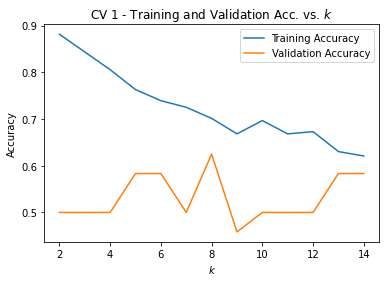

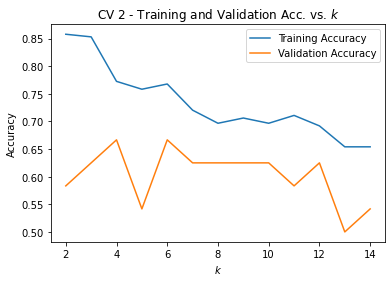

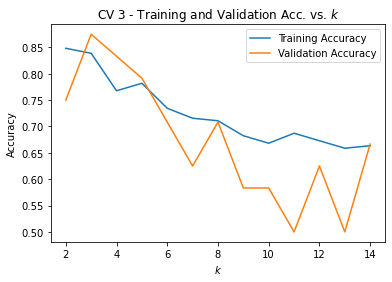

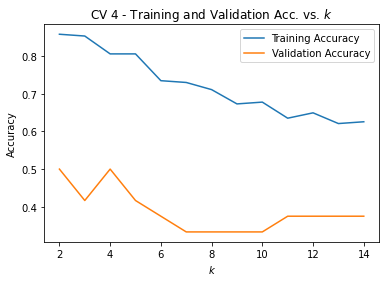

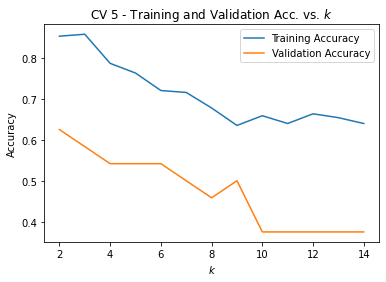

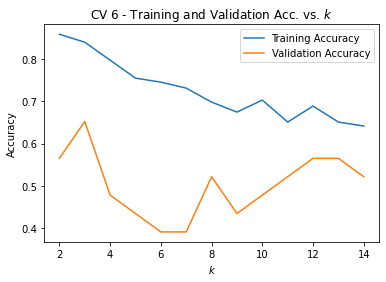

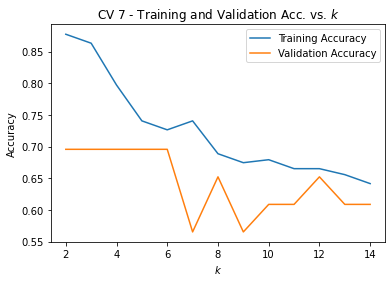

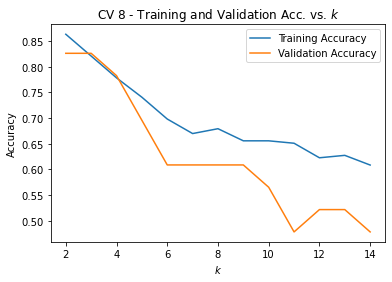

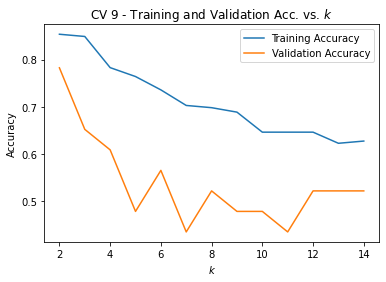

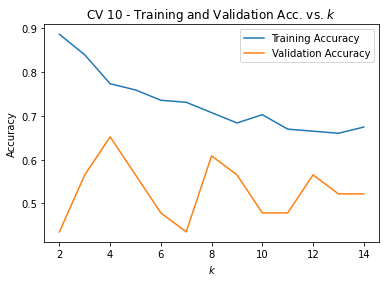

In [7]:
# TODO: fix copying y_list lines (two lines below:)
# metadata = y_list.copy()
y_list = [x['emotion'] for x in metadata]
# print(X_list[0].shape)
X_ts = to_time_series_dataset(X_list)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
splits = kf.split(videos)
K_MAX = 15
K_MIN = 2
result_dict = dict((val, []) for val in range(K_MIN, K_MAX))
for (i, (train_index, test_index)) in enumerate(splits):
    print('%d-th split' % (i+1))
    X_train, X_test = X_ts[train_index], X_ts[test_index]
    Y_train, Y_test = np.array(y_list)[train_index], np.array(y_list)[test_index]

    train_acc = []
    valid_acc = []

    for k in range(K_MIN, K_MAX):
        knn_classifier = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric='dtw')
        knn_classifier.fit(X_train, Y_train)
        train_predicted_labels = knn_classifier.predict(X_train)
        train_acc.append(accuracy_score(Y_train, train_predicted_labels))

        print("Training accuracy for k={}: {}".format(k, train_acc[-1]))
        val_predicted_labels = knn_classifier.predict(X_test)
        valid_acc.append( accuracy_score(Y_test, val_predicted_labels))
        print("Validation accuracy for k={}: {}".format(k, valid_acc[-1]))
        result_dict[k].append(valid_acc[-1])

    plt.plot(range(K_MIN, K_MAX), train_acc, label='Training Accuracy')
    plt.xlabel('$k$')
    plt.ylabel('Accuracy')
    # plt.show()

    plt.plot(range(K_MIN, K_MAX), valid_acc, label='Validation Accuracy')
    plt.title('CV %d - Training and Validation Acc. vs. $k$' % (i+1))
    plt.xlabel('$k$')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()


Min validation accuracy and average validation accuracy for each k.




In [9]:
result_df=pd.DataFrame.from_dict(result_dict,orient='index').transpose()
result_df.describe()

,2,3,4,5,6,7,8,9,10,11,12,13,14
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.626268,0.639130,0.625906,0.574457,0.561413,0.501812,0.566304,0.515217,0.502536,0.485507,0.532609,0.507246,0.519384
std,0.132757,0.138141,0.122789,0.121350,0.117571,0.102948,0.109512,0.091174,0.096260,0.077158,0.096882,0.078284,0.092889
min,0.434783,0.416667,0.478261,0.416667,0.375000,0.333333,0.333333,0.333333,0.333333,0.375000,0.375000,0.375000,0.375000
25%,0.516304,0.569746,0.510417,0.494112,0.494112,0.434783,0.521739,0.463315,0.478261,0.445652,0.505435,0.500000,0.489130
50%,0.604167,0.638587,0.630435,0.553442,0.574275,0.500000,0.608696,0.532609,0.489130,0.489130,0.543478,0.521739,0.521739
75%,0.736413,0.684783,0.688406,0.667572,0.652174,0.597826,0.625000,0.578804,0.578804,0.516304,0.610054,0.554348,0.572917
max,0.826087,0.875000,0.833333,0.791667,0.708333,0.625000,0.708333,0.625000,0.625000,0.608696,0.652174,0.608696,0.666667


In [10]:
result_df.mean()


2     0.626268
3     0.639130
4     0.625906
5     0.574457
6     0.561413
7     0.501812
8     0.566304
9     0.515217
10    0.502536
11    0.485507
12    0.532609
13    0.507246
14    0.519384
dtype: float64